<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# Inventory Dynamics


<a id='index-0'></a>

## Contents

- [Inventory Dynamics](#Inventory-Dynamics)  
  - [Overview](#Overview)  
  - [Sample Paths](#Sample-Paths)  
  - [Marginal Distributions](#Marginal-Distributions)  
  - [Exercises](#Exercises)  

## Overview

In this lecture we will study the time path of inventories for firms that
follow so-called s-S inventory dynamics.

Such firms

1. wait until inventory falls below some level $ s $ and then  
1. order sufficient quantities to bring their inventory back up to capacity $ S $.  


These kinds of policies are common in practice and also optimal in certain circumstances.

A review of early literature and some macroeconomic implications can be found in [[Caplin, 1985](https://python.quantecon.org/zreferences.html#id51)].

Here our main aim is to learn more about simulation, time series and Markov dynamics.

While our Markov environment and many of the concepts we consider are related to those found in our [lecture on finite Markov chains](https://python.quantecon.org/finite_markov.html), the state space is a continuum in the current application.

Let’s start with some imports

In [1]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
from numba import jit, float64, prange
from numba.experimental import jitclass

## Sample Paths

Consider a firm with inventory $ X_t $.

The firm waits until $ X_t \leq s $ and then restocks up to $ S $ units.

It faces stochastic demand $ \{ D_t \} $, which we assume is IID.

With notation $ a^+ := \max\{a, 0\} $, inventory dynamics can be written
as

$$
X_{t+1} =
    \begin{cases}
      ( S - D_{t+1})^+ & \quad \text{if } X_t \leq s \\
      ( X_t - D_{t+1} )^+ &  \quad \text{if } X_t > s
    \end{cases}
$$

In what follows, we will assume that each $ D_t $ is lognormal, so that

$$
D_t = \exp(\mu + \sigma Z_t)
$$

where $ \mu $ and $ \sigma $ are parameters and $ \{Z_t\} $ is IID
and standard normal.

Here’s a class that stores parameters and generates time paths for inventory.

In [2]:
firm_data = [
   ('s', float64),          # restock trigger level
   ('S', float64),          # capacity
   ('mu', float64),         # shock location parameter
   ('sigma', float64)       # shock scale parameter
]


@jitclass(firm_data)
class Firm:

    def __init__(self, s=10, S=100, mu=1.0, sigma=0.5):

        self.s, self.S, self.mu, self.sigma = s, S, mu, sigma

    def update(self, x):
        "Update the state from t to t+1 given current state x."

        Z = np.random.randn()
        D = np.exp(self.mu + self.sigma * Z)
        if x <= self.s:
            return max(self.S - D, 0)
        else:
            return max(x - D, 0)

    def sim_inventory_path(self, x_init, sim_length):

        X = np.empty(sim_length)
        X[0] = x_init

        for t in range(sim_length-1):
            X[t+1] = self.update(X[t])
        return X

Let’s run a first simulation, of a single path:

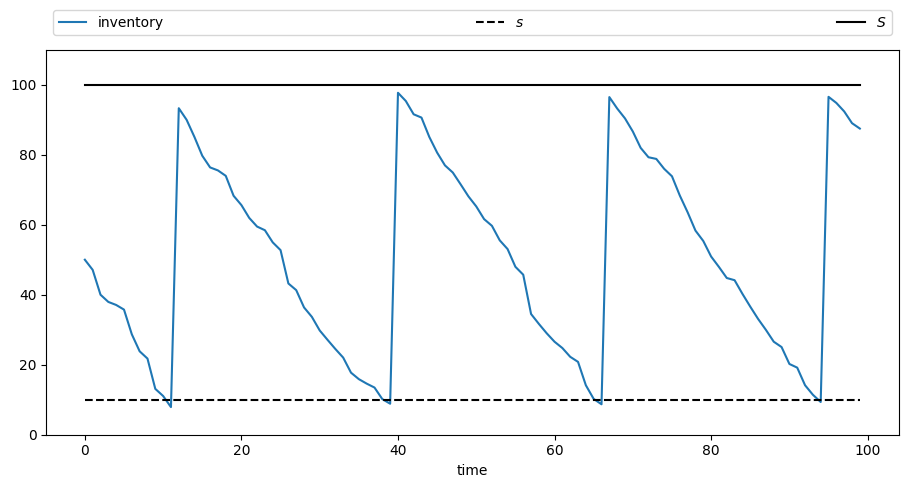

In [3]:
firm = Firm()

s, S = firm.s, firm.S
sim_length = 100
x_init = 50

X = firm.sim_inventory_path(x_init, sim_length)

fig, ax = plt.subplots()
bbox = (0., 1.02, 1., .102)
legend_args = {'ncol': 3,
               'bbox_to_anchor': bbox,
               'loc': 3,
               'mode': 'expand'}

ax.plot(X, label="inventory")
ax.plot(np.full(sim_length, s), 'k--', label="$s$")
ax.plot(np.full(sim_length, S), 'k-', label="$S$")
ax.set_ylim(0, S+10)
ax.set_xlabel("time")
ax.legend(**legend_args)

plt.show()

Now let’s simulate multiple paths in order to build a more complete picture of
the probabilities of different outcomes:

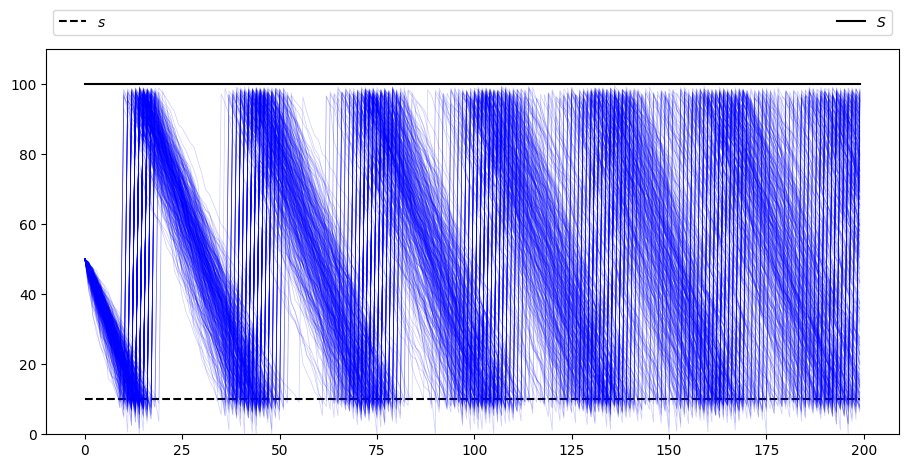

In [4]:
sim_length=200
fig, ax = plt.subplots()

ax.plot(np.full(sim_length, s), 'k--', label="$s$")
ax.plot(np.full(sim_length, S), 'k-', label="$S$")
ax.set_ylim(0, S+10)
ax.legend(**legend_args)


# 每次都会调用 update() 200 次，每次都会遇到不同的 Z，所以每条路径都是随机的。
for i in range(400):
    X = firm.sim_inventory_path(x_init, sim_length)
    ax.plot(X, 'b', alpha=0.2, lw=0.5)

plt.show()

## Marginal Distributions

Now let’s look at the marginal distribution $ \psi_T $ of $ X_T $ for some
fixed $ T $.

We will do this by generating many draws of $ X_T $ given initial
condition $ X_0 $.

With these draws of $ X_T $ we can build up a picture of its distribution $ \psi_T $.

Here’s one visualization, with $ T=50 $.

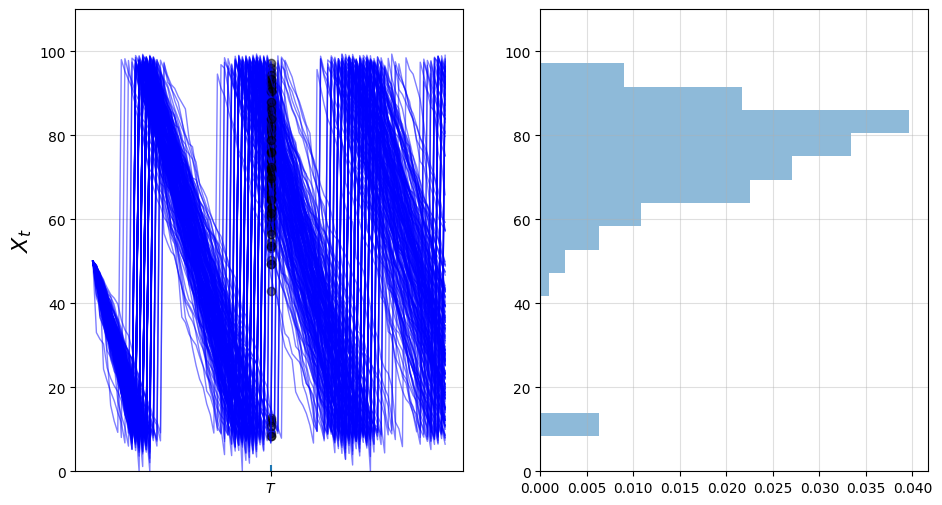

In [5]:
T = 50
M = 200  # Number of draws
# 生成 200 条库存路径 进行 Monte Carlo 仿真。

ymin, ymax = 0, S + 10

fig, axes = plt.subplots(1, 2, figsize=(11, 6))
# 创建一个 1 行 2 列 的子图布局：
# axes[0]：用于绘制库存路径。
# axes[1]：用于绘制 T+1 处的库存分布（直方图）。

for ax in axes:
    ax.grid(alpha=0.4)


ax = axes[0]  # 选择左侧图像（库存路径图）

ax.set_ylim(ymin, ymax)  # 设定 Y 轴范围
ax.set_ylabel('$X_t$', fontsize=16)  # 设置 Y 轴标签
ax.vlines((T,), -1.5, 1.5)  # 在 T 位置画一条竖线

ax.set_xticks((T,))  # X 轴刻度仅设置 T
ax.set_xticklabels((r'$T$',))  # T 处的刻度标注为 'T'




sample = np.empty(M)  # 创建一个长度为 M 的数组，用于存储 X[T+1]
for m in range(M):
    X = firm.sim_inventory_path(x_init, 2 * T)  # 生成 2T 期的库存路径
    ax.plot(X, 'b-', lw=1, alpha=0.5)  # 画出库存路径
    ax.plot((T,), (X[T+1],), 'ko', alpha=0.5)  # 在 T+1 处标出库存值
      # 这里的 (T,) 只是为了让 X[T+1] 画在 T 轴位置，但 实际数据点是 X[T+1]，它是 T 期结束后的库存。
    sample[m] = X[T+1]  # 记录 X[T+1] 进入数组


axes[1].set_ylim(ymin, ymax)

axes[1].hist(sample,
             bins=16,
             density=True,
             orientation='horizontal',
             histtype='bar',
             alpha=0.5)

plt.show()

We can build up a clearer picture by drawing more samples

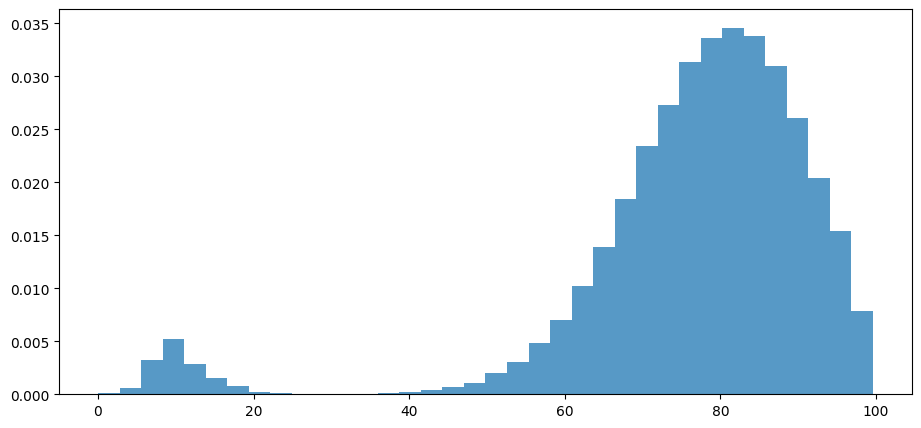

In [6]:
T = 50
M = 50_000

fig, ax = plt.subplots()

sample = np.empty(M)
for m in range(M):
    X = firm.sim_inventory_path(x_init, T+1)
    sample[m] = X[T]

ax.hist(sample,
         bins=36,
         density=True,
         histtype='bar',
         alpha=0.75)

plt.show()

Note that the distribution is bimodal

- Most firms have restocked twice but a few have restocked only once (see figure with paths above).  
- Firms in the second category have lower inventory.  


We can also approximate the distribution using a [kernel density estimator](https://en.wikipedia.org/wiki/Kernel_density_estimation).

Kernel density estimators can be thought of as smoothed histograms.

They are preferable to histograms when the distribution being estimated is likely to be smooth.

We will use a kernel density estimator from [scikit-learn](https://scikit-learn.org/stable/)

In [7]:
from sklearn.neighbors import KernelDensity

def plot_kde(sample, ax, label=''):

    xmin, xmax = 0.9 * min(sample), 1.1 * max(sample)
    xgrid = np.linspace(xmin, xmax, 200)
    kde = KernelDensity(kernel='gaussian').fit(sample[:, None])
    log_dens = kde.score_samples(xgrid[:, None])

    ax.plot(xgrid, np.exp(log_dens), label=label)

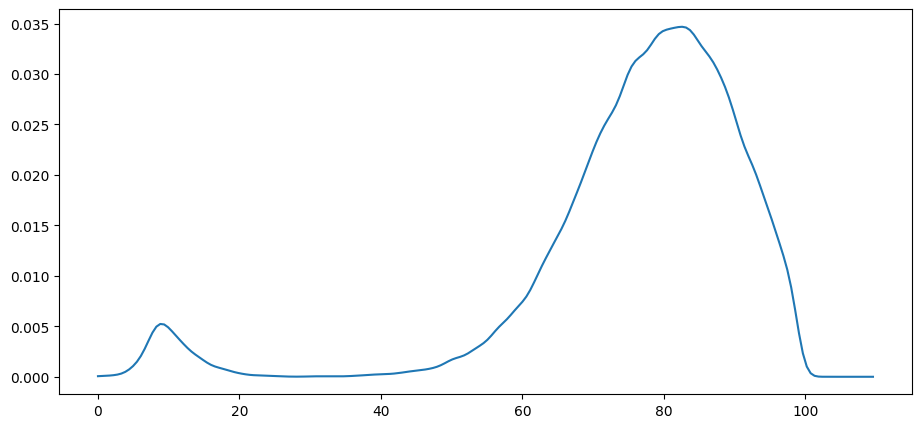

In [8]:
fig, ax = plt.subplots()
plot_kde(sample, ax)
plt.show()

The allocation of probability mass is similar to what was shown by the
histogram just above.

用一组样本数据来估计这个变量的真实分布，而不是假设它服从某个已知的分布（比如正态分布）。它通过在每个数据点周围放置一个平滑的“核函数”（kernel），然后把所有这些核函数加起来，得到平滑的分布曲线。**



## Exercises

## Exercise 20.1

This model is asymptotically stationary, with a unique stationary
distribution.

(See the discussion of stationarity in [our lecture on AR(1) processes](https://intro.quantecon.org/ar1_processes.html) for background — the fundamental concepts are the same.)

In particular, the sequence of marginal distributions $ \{\psi_t\} $
is converging to a unique limiting distribution that does not depend on
initial conditions.

Although we will not prove this here, we can investigate it using simulation.

Your task is to generate and plot the sequence $ \{\psi_t\} $ at times
$ t = 10, 50, 250, 500, 750 $ based on the discussion above.

(The kernel density estimator is probably the best way to present each
distribution.)

You should see convergence, in the sense that differences between successive distributions are getting smaller.

Try different initial conditions to verify that, in the long run, the distribution is invariant across initial conditions.

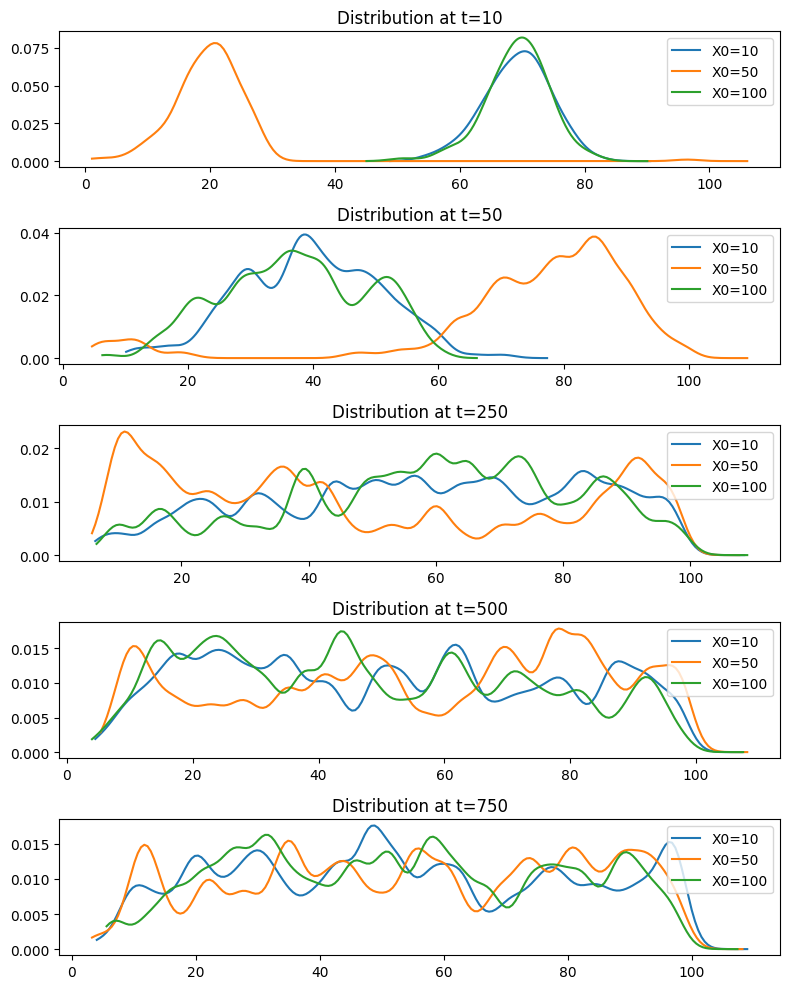

In [11]:
# 这个只是手动设置了几家公司 所以不对 还是应该参考标准答案
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

# 设置参数
T_list = [10, 50, 250, 500, 750]  # 观察的时间点
M = 200  # 模拟路径数
initial_conditions = [10, 50, 100]  # 不同的初始库存值

# 定义 KDE 绘图函数
def plot_kde(sample, ax, label=''):
    xmin, xmax = 0.9 * min(sample), 1.1 * max(sample)  # 设定 X 轴范围
    xgrid = np.linspace(xmin, xmax, 200)  # 生成等间距 X 值
    kde = KernelDensity(kernel='gaussian', bandwidth=2.0).fit(sample[:, None])  # KDE 估计
    log_dens = kde.score_samples(xgrid[:, None])  # 计算密度
    ax.plot(xgrid, np.exp(log_dens), label=label)  # 绘制 KDE 曲线

# 画布设置
fig, axes = plt.subplots(len(T_list), 1, figsize=(8, 10))  # 每个 T 画一张图

# 遍历每个时间点 T
for i, T in enumerate(T_list):
    ax = axes[i]
    ax.set_title(f"Distribution at t={T}")

    # 遍历不同初始库存值
    for x_init in initial_conditions:
        sample = np.empty(M)  # 用于存储 M 次模拟的 X_T 值

        # 进行 M 次模拟
        for m in range(M):
            X = firm.sim_inventory_path(x_init, T+1)  # 运行到 T+1
            sample[m] = X[T]  # 记录 T 时刻的库存值

        # 绘制 KDE 分布
        plot_kde(sample, ax, label=f'X0={x_init}')

    ax.legend()

plt.tight_layout()
plt.show()


## Solution to[ Exercise 20.1](https://python.quantecon.org/#id_ex1)

Below is one possible solution:

The computations involve a lot of CPU cycles so we have tried to write the
code efficiently.

This meant writing a specialized function rather than using the class above.

In [9]:
s, S, mu, sigma = firm.s, firm.S, firm.mu, firm.sigma

@jit(parallel=True)
def shift_firms_forward(current_inventory_levels, num_periods):

    num_firms = len(current_inventory_levels)
    new_inventory_levels = np.empty(num_firms)

    for f in prange(num_firms):
        x = current_inventory_levels[f]
        for t in range(num_periods):
            Z = np.random.randn()
            D = np.exp(mu + sigma * Z)
            if x <= s:
                x = max(S - D, 0)
            else:
                x = max(x - D, 0)
        new_inventory_levels[f] = x

    return new_inventory_levels

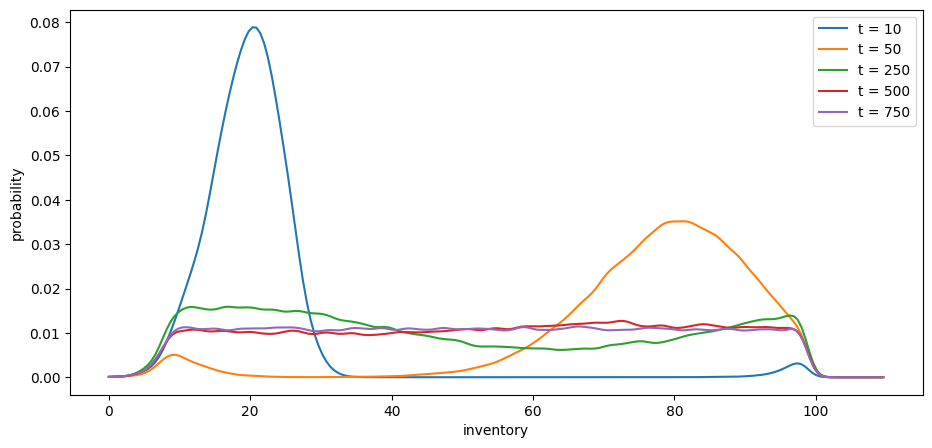

In [10]:
x_init = 50
num_firms = 50_000

sample_dates = 0, 10, 50, 250, 500, 750

first_diffs = np.diff(sample_dates)
  # 计算相邻时间点之间的差值，得到：
  # first_diffs = [10, 40, 200, 250, 250]
  # 这意味着：
    # 先模拟 10 期（从 t=0 到 t=10）。
    # 再继续 40 期（t=10 到 t=50）。
    # 然后 200 期（t=50 到 t=250）。
    # 依此类推，最终到 t=750。

fig, ax = plt.subplots()

X = np.full(num_firms, x_init)
# X 是一个大小为 num_firms=50,000 的 numpy 数组，所有值都是 50。
# 这表示所有公司的库存初始值为 50。

current_date = 0
for d in first_diffs:
    X = shift_firms_forward(X, d)
    current_date += d
    plot_kde(X, ax, label=f't = {current_date}')

ax.set_xlabel('inventory')
ax.set_ylabel('probability')
ax.legend()
plt.show()

Notice that by $ t=500 $ or $ t=750 $ the densities are barely
changing.

We have reached a reasonable approximation of the stationary density.

You can convince yourself that **initial conditions don’t matter** by
testing a few of them.

For example, try rerunning the code above with all firms starting at
$ X_0 = 20 $ or $ X_0 = 80 $.

## Exercise 20.2

Using simulation, calculate the probability that firms that start with
$ X_0 = 70 $ need to order twice or more in the first 50 periods.

You will need a large sample size to get an accurate reading.

In [14]:
import numpy as np

# 设定参数
X_0 = 70  # 初始库存
T = 50  # 模拟 50 期
num_firms = 100_000  # 进行 10 万次模拟
s, S, mu, sigma = firm.s, firm.S, firm.mu, firm.sigma  # 读取 firm 设定的参数

# 记录补货次数
order_counts = np.zeros(num_firms)  # 每个公司的补货次数初始化为 0

# 进行模拟
X = np.full(num_firms, X_0)  # 初始化所有公司的库存
for t in range(T):  # 模拟 50 期
    Z = np.random.randn(num_firms)  # 生成 num_firms 个标准正态随机数
    D = np.exp(mu + sigma * Z)  # 计算需求量 D_t

    # 记录补货
    restock = X <= s  # 判断哪些公司库存小于等于 s，需要补货
    order_counts += restock  # 这些公司补货次数 +1
    X = np.where(restock, np.maximum(S - D, 0), np.maximum(X - D, 0))  # 更新库存

# 计算补货次数 >= 2 的概率
probability = np.mean(order_counts >= 2)

print(f"概率：{probability:.4f}")


概率：0.4478


In [15]:
print(order_counts)

[1. 1. 2. ... 1. 2. 2.]


## Solution to[ Exercise 20.2](https://python.quantecon.org/#id_ex2)

Here is one solution.

Again, the computations are relatively intensive so we have written a a
specialized function rather than using the class above.

We will also use parallelization across firms.

In [12]:
@jit(parallel=True)
def compute_freq(sim_length=50, x_init=70, num_firms=1_000_000):

    firm_counter = 0  # Records number of firms that restock 2x or more
    for m in prange(num_firms): #prange() 让 numba 并行执行循环，加速计算。
        x = x_init
        restock_counter = 0  # Will record number of restocks for firm m

        for t in range(sim_length):
            Z = np.random.randn()
            D = np.exp(mu + sigma * Z)
            if x <= s:
                x = max(S - D, 0)
                restock_counter += 1
            else:
                x = max(x - D, 0)

        if restock_counter > 1:
            firm_counter += 1

    return firm_counter / num_firms

Note the time the routine takes to run, as well as the output.

In [13]:
%%time

freq = compute_freq()
print(f"Frequency of at least two stock outs = {freq}")

Frequency of at least two stock outs = 0.446733
CPU times: user 4.02 s, sys: 3.78 ms, total: 4.03 s
Wall time: 2.4 s


Try switching the `parallel` flag to `False` in the jitted function
above.

Depending on your system, the difference can be substantial.

(On our desktop machine, the speed up is by a factor of 5.)